In [87]:
from datetime import datetime
from joblib import Parallel, delayed
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

In [88]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [89]:
from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_hr
)

In [90]:
def get_predicted_peaks(signal):
    return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0.15, with_min_dist = True, with_valleys = False)
def get_true_peaks(signal):
    return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0.15, with_min_dist = True, with_valleys = False)

def _process(targs, signal, smoothing_window = 10, use_bandpass = False):
    
    orig_len = len(signal)
    signal = n_moving_avg(signal, smoothing_window)
    signal = resample(signal, orig_len)
    if use_bandpass:
        signal = bandpass(signal, 64, [0.67, 3.0], 4)
    signal = min_max_scale(signal)
    
    targs = n_moving_avg(targs, 20)
    targs = resample(targs, orig_len)
    if use_bandpass:
        targs = bandpass(targs, 64, [0.67, 3.0], 4)
    targs = min_max_scale(targs)
    
    return targs, signal

In [91]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [92]:
class LossFactory:

    def __init__(self, total_samples, split_size, loss_type = 'mse', gamma = 1.0, mse_weight = None, dtw_weight = None):
        
        if loss_type not in ['mse', 'dtw', 'combined']:
            raise ValueError(f'Loss type [{loss_type}] not supported')
        
        self.total_samples = total_samples
        self.split_size = split_size
        self.gamma = gamma
        self.mse_weight = mse_weight
        self.dtw_weight = dtw_weight

        if loss_type == 'mse':
            self.loss_function = self.mse_loss
        elif loss_type == 'dtw':
            self.loss_function = self.soft_dtw_loss
        elif loss_type == 'combined':
            self.loss_function = self.combined_loss
        
    def __call__(self, y_pred, data):
        return self.loss_function(y_pred, data)

    def mse_loss(self, y_pred, data):
        
        y_true = data.get_label()
        num_batches = int(self.total_samples / self.split_size)
        errs = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            err = y_true_curr - y_pred_curr
            errs[i * self.split_size: (i + 1) * self.split_size] = err

        grad = -2 * errs
        hess = 2 * np.ones_like(y_true)
        return grad, hess

    def soft_dtw_loss(self, y_pred, data):

        y_true = data.get_label()
        num_batches = int(self.total_samples / self.split_size)
        grads = np.zeros_like(y_true)
        hesses = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            grad_curr, hess_curr = self.soft_dtw_loss_helper(y_true_curr, y_pred_curr)
            grad_curr = grad_curr.flatten()
            hess_curr = hess_curr.flatten()

            grads[i * self.split_size: (i + 1) * self.split_size] = grad_curr
            hesses[i * self.split_size: (i + 1) * self.split_size] = hess_curr

        return grads, hesses
    
    def soft_dtw_loss_helper(self, y_true, y_pred):
        x = y_true.reshape(-1, 1)
        y = y_pred.reshape(-1, 1)
        D = SquaredEuclidean(x, y)
        sdtw = SoftDTW(D, gamma = self.gamma)
        sdtw.compute()
        E = sdtw.grad()
        G = D.jacobian_product(E)
        return G, np.ones(len(G))
    
    def combined_loss(self, y_pred, data):

        if self.mse_weight is None or self.dtw_weight is None:
            raise ValueError('mse_weight and dtw_weight must be set before calling combined_loss')

        mse_grads, mse_hesses = self.mse_loss(y_pred, data)
        dtw_grads, dtw_hesses = self.soft_dtw_loss(y_pred, data)

        print(f'mse grads: {mse_grads[0: 10]}')
        print(f'dtw grads: {dtw_grads[0: 10]}')

        combined_grad = self.mse_weight * mse_grads + self.dtw_weight * dtw_grads
        combined_hess = self.mse_weight * mse_hesses + self.dtw_weight * dtw_hesses

        return combined_grad, combined_hess

In [93]:
class LonePineGBM:
    
    def __init__(self, truths, label_col = 'bvp', subject_col = 'subject',
                # model customization
                model_type = 'gbdt', random_state = 0, loss_type = 'mse', excluded_subject = None,
                # hyperparameters
                n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3,
                data_beg = 1000, data_end = 10000):
        
        if model_type not in ['gbdt', 'rf']:
            raise ValueError(f'Model type [{model_type}] not supported')
        
        self.label_col = label_col
        self.subject_col = subject_col
        self.split_size = split_size
        self.learning_rate = learning_rate
        self.test_size = test_size
        self.random_state = random_state,
        self.n_estimators = n_estimators
        self.gbm = None
        self.training_loss = None

        self.given_data = self.prepare_dataset_from_subjects(truths, data_beg = data_beg, data_end = data_end)
        self.features = list(self.given_data.drop(columns = [self.label_col, self.subject_col]).columns)
        self.excluded_subject = excluded_subject
        if self.excluded_subject is not None:
            self.given_data = self.given_data[self.given_data[self.subject_col] != self.excluded_subject]

        # random.seed(self.random_state)
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        train_indices = [idx for split in self.train_splits for idx in split]
        self.train_data = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
        self.train_X = self.train_data.drop(columns = [self.label_col]).to_numpy()
        self.train_y = self.train_data[self.label_col].to_numpy()

        test_indices = [idx for split in self.test_splits for idx in split]
        self.test_data = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        self.test_X = self.test_data.drop(columns = [self.label_col]).to_numpy()
        self.test_y = self.test_data[self.label_col].to_numpy()

        self.train_data = lgb.Dataset(self.train_X, self.train_y)
        self.test_data = lgb.Dataset(self.test_X, self.test_y)

        self.loss = LossFactory(len(self.train_X), self.split_size, loss_type = loss_type, mse_weight = 0.5, dtw_weight = 0.5)
    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits
    
    def augment_data(self):
        pass

    def fit(self):
        
        t1 = datetime.today()
        params = {
            'metric': 'None',
            'verbosity': -1,
            # 'seed': self.random_state,
            'learning_rate': self.learning_rate,
            'objective': 'regression'
        }

        training_loss_key = 'peaks_err'
        feval = self.peaks_discovered_eval_metric
        
        training_meta = {}
        self.gbm = lgb.train(
            params,
            self.train_data,
            valid_sets = [self.train_data, self.test_data],
            valid_names=['train', 'test'],
            fobj = self.loss,
            num_boost_round = self.n_estimators,
            feval=feval,
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(period=1)
            ],
            evals_result = training_meta
        )
        
        self.training_loss = training_meta['train'][training_loss_key]
        self.test_loss = training_meta['test'][training_loss_key]
        print(f'Finished training in {datetime.today() - t1}')

    def predict(self, X):
        return self.gbm.predict(X)

    def eval(self):
        
        errs = []
        nsplits = int(len(self.test_X) / self.split_size)
        mses = np.ones_like(self.test_y)
        for i in range(nsplits):

            curr_pred = self.predict(self.test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = self.test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = _process(curr_true, curr_pred, smoothing_window=5, use_bandpass=True)
            mses[i * self.split_size: (i + 1) * self.split_size] = curr_true - curr_pred

            hr_err = self.get_peaks_difference(curr_true, curr_pred, square = False)
            errs.append(hr_err)
        
        return np.mean(np.square(mses)), np.mean(errs), np.mean(np.square(errs))

    def plot_loss(self):
        if self.training_loss is not None and self.test_loss is not None:
            training_loss_normed = min_max_scale(self.training_loss)
            test_loss_normed = min_max_scale(self.test_loss)
            plt.plot(training_loss_normed, label = 'training loss')
            plt.plot(test_loss_normed, label = 'test loss')
            plt.legend()
        
    def get_model_stats(self):

        model_info = self.gbm.dump_model()
        tree_depths = []

        for tree_info in model_info['tree_info']:
            tree_structure = tree_info['tree_structure']
            
            # Recursive function to compute the depth of a tree
            def calculate_depth(node, current_depth=0):
                if 'leaf_value' in node:
                    return current_depth
                else:
                    left_depth = calculate_depth(node['left_child'], current_depth + 1)
                    right_depth = calculate_depth(node['right_child'], current_depth + 1)
                    return max(left_depth, right_depth)

            tree_depth = calculate_depth(tree_structure)
            tree_depths.append(tree_depth)

        print('Tree depth stats:')
        print('Min tree depth:', min(tree_depths))
        print('Max tree depth:', max(tree_depths))
        print('Avg tree depth:', np.mean(tree_depths))
        print('\nFeature importances:')
        display(self.get_feature_importances())
    
    def get_feature_importances(self):
        importances = self.gbm.feature_importance(importance_type='gain')
        feature_importances = pd.DataFrame({'feature': self.features, 'importance': importances})
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        return feature_importances
    
    @staticmethod
    def prepare_dataset_from_subjects(truths, data_beg = 1000, data_end = 2000):
        data_arr = []
        for i in range(len(truths)):    
            truth = truths[i]
            data = truth.prepare_data_for_ml()
            data = data.iloc[data_beg: data_end, :]
            data['subject'] = i + 1
            data_arr.append(data)
        return pd.concat(data_arr)
    
    def hr_error_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        hr_err = 0
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = _process(curr_true, curr_pred)
            hr_err += self.get_hr_error(curr_true, curr_pred, square = True)
        return 'hr_err', hr_err, False
    
    def peaks_discovered_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        peaks_err = 0
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = _process(curr_true, curr_pred)
            peaks_err += self.get_peaks_difference(curr_true, curr_pred, square = True)
        return 'peaks_err', peaks_err, False
    
    @staticmethod
    def get_hr_error(y_true, y_pred, square = True):

        true_peaks, _ = get_true_peaks(y_true)
        pred_peaks, _ = get_predicted_peaks(y_pred)

        true_ibis = np.diff(true_peaks) / 64
        true_hr = 60 / np.mean(true_ibis)

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hr = 60 / np.mean(pred_ibis)
        else:
            pred_hr = 0
        
        if square:
            return np.power(true_hr - pred_hr, 2)
        return abs(true_hr - pred_hr)
    
    @staticmethod
    def get_peaks_difference(y_true, y_pred, square = True):
            
        true_peaks, _ = get_true_peaks(y_true)
        pred_peaks, _ = get_predicted_peaks(y_pred)

        if square:
            return np.power(len(true_peaks) - len(pred_peaks), 2)
        return abs(len(true_peaks) - len(pred_peaks))

In [94]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = LonePineGBM(truths, n_estimators = 3, loss_type = 'combined', split_size = 960, excluded_subject = test_subject, model_type = 'gbdt', learning_rate = 0.0065)
mod.fit()

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


mse grads: [-0.21440949 -0.20743604 -0.19401552 -0.1775688  -0.16085893 -0.14625423
 -0.13559674 -0.12941274 -0.12730752 -0.12743904]
dtw grads: [0.37076455 0.3588982  0.33600885 0.30786952 0.27918747 0.25404894
 0.23566686 0.22498706 0.22134915 0.22157645]
[1]	train's peaks_err: 1280	test's peaks_err: 951
Training until validation scores don't improve for 50 rounds
mse grads: [-0.2143027  -0.20732926 -0.1938463  -0.17739958 -0.16068971 -0.14626032
 -0.13560283 -0.12941884 -0.12731361 -0.12744513]
dtw grads: [0.370564   0.35868248 0.3358014  0.30769432 0.2790568  0.25396413
 0.23562312 0.22497757 0.22136706 0.22161531]
[2]	train's peaks_err: 1276	test's peaks_err: 894
mse grads: [-0.2141957  -0.20722225 -0.19368356 -0.17723684 -0.16052698 -0.14626637
 -0.13560888 -0.12942488 -0.12731966 -0.12745118]
dtw grads: [0.37035766 0.35846397 0.3355931  0.30751875 0.27892527 0.25387767
 0.2355769  0.22496483 0.22138107 0.22164974]
[3]	train's peaks_err: 1260	test's peaks_err: 747
Did not meet ea



MSE: 0.10517801105767646
Peaks error: 4.666666666666667
Peaks error squared: 44.266666666666666


Tree depth stats:
Min tree depth: 10
Max tree depth: 10
Avg tree depth: 10.0

Feature importances:


,feature,importance
33,b_mem_7,8.304586
0,chrom,5.481602
32,g_mem_7,4.059046
28,r_mem_6,2.099696
21,b_mem_3,1.654449
31,r_mem_7,1.621615
9,b_acc,1.591877
20,g_mem_3,1.521836
14,g_mem_1,1.097183
3,b,1.032490


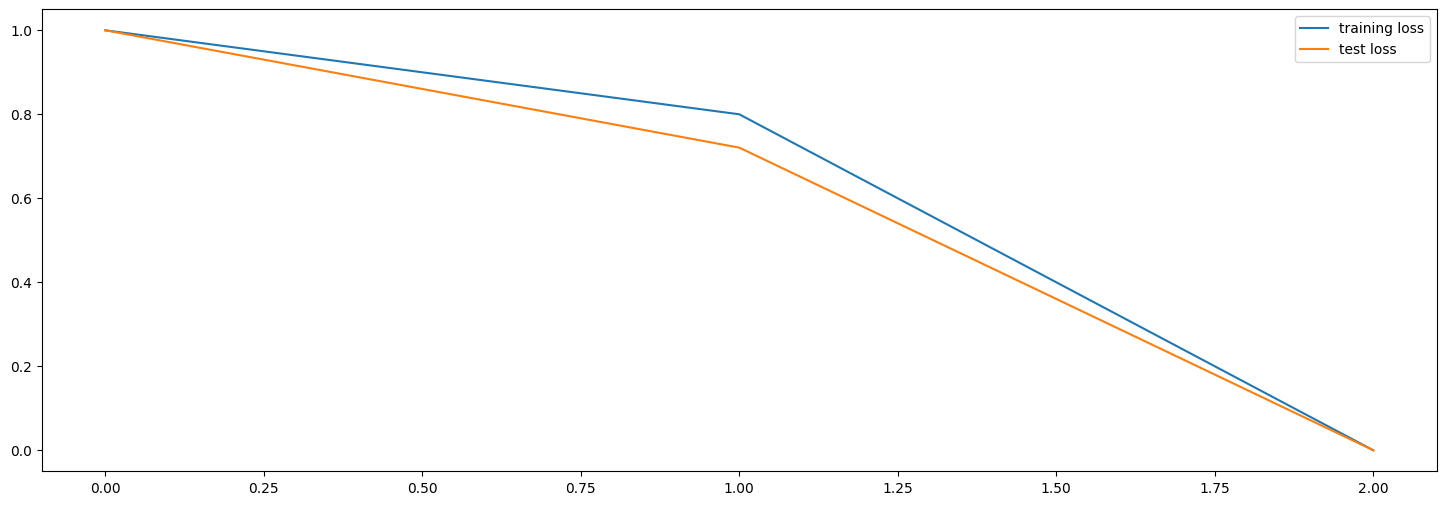

In [95]:
mse, hr_err, hr_err_sq = mod.eval()

print(f'\n\nMSE: {mse}')
print(f'Peaks error: {hr_err}')
print(f'Peaks error squared: {hr_err_sq}\n\n')

mod.get_model_stats()
mod.plot_loss()